In [ ]:
!pip install -q numpy==1.24.4 scikit-surprise openpyxl
!pip install -q ctransformers pandas transformers accelerate bitsandbytes

import os
os.kill(os.getpid(), 9)

# Phase 1

Traditional + Content + Hybrid Recommendation

Saving RS.zip to RS.zip
RMSE: 0.7780


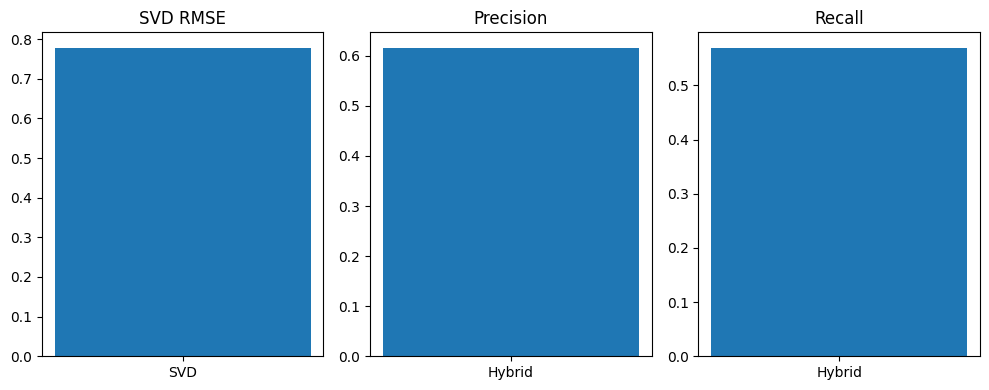

In [1]:
import zipfile, os
from google.colab import files
import pandas as pd
import numpy as np
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise.accuracy import rmse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from collections import defaultdict
import matplotlib.pyplot as plt

uploaded = files.upload()
with zipfile.ZipFile("RS.zip", "r") as zip_ref:
    zip_ref.extractall("RS")

movies = pd.read_csv("RS/movies.csv")
ratings = pd.read_csv("RS/ratings.csv")

reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2)
svd = SVD()
svd.fit(trainset)
svd_preds = svd.test(testset)
svd_rmse = rmse(svd_preds)

tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['genres'].fillna(''))
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
indices = pd.Series(movies.index, index=movies['movieId'])

def get_hybrid_recommendations(user_id, top_n=10):
    watched = set(ratings[ratings.userId == user_id].movieId)
    movie_scores = []
    for movieId in movies['movieId'].values:
        if movieId in watched: continue
        try: svd_score = svd.predict(user_id, movieId).est
        except: svd_score = 0
        idx = indices.get(movieId)
        content_score = cosine_sim[idx].mean() if idx is not None else 0
        hybrid_score = (svd_score + content_score) / 2
        movie_scores.append((movieId, hybrid_score))

    top_movies = sorted(movie_scores, key=lambda x: x[1], reverse=True)[:top_n]
    return pd.merge(pd.DataFrame(top_movies, columns=['movieId', 'score']), movies, on='movieId')

def precision_recall_at_k(predictions, k=10, threshold=3.5):
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
    precisions, recalls = {}, {}
    for uid, ratings in user_est_true.items():
        ratings.sort(key=lambda x: x[0], reverse=True)
        top_k = ratings[:k]
        n_rel = sum((true >= threshold) for (_, true) in ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in top_k)
        n_rel_and_rec_k = sum(((true >= threshold) and (est >= threshold)) for (est, true) in top_k)
        precisions[uid] = n_rel_and_rec_k / k
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel else 0
    return precisions, recalls

precisions, recalls = precision_recall_at_k(svd_preds, k=10)

plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1); plt.title("SVD RMSE"); plt.bar(['SVD'], [svd_rmse])
plt.subplot(1, 3, 2); plt.title("Precision"); plt.bar(['Hybrid'], [np.mean(list(precisions.values()))])
plt.subplot(1, 3, 3); plt.title("Recall"); plt.bar(['Hybrid'], [np.mean(list(recalls.values()))])
plt.tight_layout(); plt.show()

recs_user1 = get_hybrid_recommendations(1, top_n=10)
recs_user1.to_csv("recommendations_user1.csv", index=False)


# Phase 2

LLM-based Explanation using Mistral

In [2]:
from ctransformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(
    "TheBloke/Mistral-7B-Instruct-v0.1-GGUF",
    model_file="mistral-7b-instruct-v0.1.Q4_K_M.gguf",
    model_type="mistral",
    max_new_tokens=200,
    temperature=0.7,
    gpu_layers=0
)
recommendations = pd.read_csv("recommendations_user1.csv")

def generate_explanation(title, score):
    prompt = f"[INST] Explain in 2–3 sentences why the movie '{title}' might be recommended to a user based on their past preferences and a score of {score:.2f}. [/INST]"
    return model(prompt)

recommendations["explanation"] = recommendations.apply(lambda row: generate_explanation(row["title"], row["score"]), axis=1)
recommendations.to_csv("recommendations_with_explanations.csv", index=False)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/31.0 [00:00<?, ?B/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

mistral-7b-instruct-v0.1.Q4_K_M.gguf:   0%|          | 0.00/4.37G [00:00<?, ?B/s]

Explanations saved to 'recommendations_with_explanations.csv'


# Phase 3

Cold-Start + Tag Profile Analysis

In [5]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import vstack, csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import re

tags = pd.read_csv("RS/tags.csv")
genome_tags = pd.read_csv("RS/genome-tags.csv")
genome_scores = pd.read_csv("RS/genome-scores.csv")
movies = pd.read_csv("RS/movies.csv")

movie_tags = tags.groupby('movieId')['tag'].apply(lambda x: ' '.join(str(t) for t in x)).reset_index()
movie_info = movies.merge(movie_tags, on='movieId', how='left')
movie_info['tag'] = movie_info['tag'].fillna('')

vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(movie_info['tag'])

liked_titles = ["The Matrix (1999)", "Inception (2010)", "Blade Runner (1982)"]
liked_vectors = movie_info[movie_info['title'].isin(liked_titles)]['tag'].apply(lambda x: vectorizer.transform([x])).tolist()
user_vector_mean = vstack(liked_vectors).mean(axis=0)
user_vector_mean = csr_matrix(user_vector_mean)

similarities = cosine_similarity(user_vector_mean, tfidf_matrix).flatten()
movie_info['similarity'] = similarities

top_recommendations = movie_info[~movie_info['title'].isin(liked_titles)].sort_values(by='similarity', ascending=False)
print("Top Cold-Start Recommendations:\n", top_recommendations[['title', 'similarity']].head(10))

liked_data = movie_info[movie_info['title'].isin(liked_titles)]
all_tags_text = ' '.join(liked_data['tag'].tolist())
all_genres = ' '.join(liked_data['genres'].tolist())

tag_tokens = re.findall(r'\b\w+\b', all_tags_text.lower())
genre_tokens = all_genres.replace('|', ' ').lower().split()

top_tags = [tag for tag, _ in Counter(tag_tokens).most_common(5)]
top_genres = [genre for genre, _ in Counter(genre_tokens).most_common(3)]

print(f"""
User Profile Summary:
- Favorite genres: {', '.join(top_genres)}
- Likes themes such as: {', '.join(top_tags)}
- Based on liked movies: {', '.join(liked_titles)}
""")


Top Cold-Start Recommendations:
                                                title  similarity
1678                                Dark City (1998)    0.562717
2480                              Matrix, The (1999)    0.556518
48302                       Blade Runner 2049 (2017)    0.507723
62051                                 Haphead (2015)    0.476269
15674                            Tron: Legacy (2010)    0.461788
18312                            Total Recall (2012)    0.444322
18777  Vexille (Bekushiru: 2077 Nihon sakoku) (2007)    0.441964
13266                                    Moon (2009)    0.434564
1591                                  Gattaca (1997)    0.421914
7931                                 I, Robot (2004)    0.421672

User Profile Summary:
- Favorite genres: action, sci-fi, thriller
- Likes themes such as: fi, sci, reality, visually, alternate
- Based on liked movies: The Matrix (1999), Inception (2010), Blade Runner (1982)



# Phase 4

Dashboard

In [9]:
recs = pd.read_csv("recommendations_user1.csv")
explanations = pd.read_csv("recommendations_with_explanations.csv")

print(f"\n\U0001F3AC Movie Recommendations for User 1\nTop-N Hybrid Recommendations:")
for idx, row in recs.head(10).iterrows():
    print(f"{idx+1}. {row['title']} (Score: {row['score']:.4f})")

print("\n Why These Movies?")
for idx, row in explanations.iterrows():
    print(f"\U0001F3A5 {row['title']}: {row['explanation']}")

feedback = input("\nWhich movie did you like from these recommendations? ")
print("Thank you! Your feedback has been recorded.")



🎬 Movie Recommendations for User 1
Top-N Hybrid Recommendations:
1. Celebration, The (Festen) (1998) (Score: 2.5451)
2. Antonia's Line (Antonia) (1995) (Score: 2.5368)
3. Lives of Others, The (Das leben der Anderen) (2006) (Score: 2.4148)
4. Six Shooter (2004) (Score: 2.4143)
5. Planet Earth II (2016) (Score: 2.4119)
6. Band of Brothers (2001) (Score: 2.4098)
7. Life Is Beautiful (La Vita è bella) (1997) (Score: 2.4091)
8. One Flew Over the Cuckoo's Nest (1975) (Score: 2.4073)
9. Best of Youth, The (La meglio gioventù) (2003) (Score: 2.4003)
10. Some Folks Call It a Sling Blade (1993) (Score: 2.3893)

 Why These Movies?
🎥 Celebration, The (Festen) (1998):  Based on their past preferences, the user may enjoy the dark, psychological thriller genre of 'Celebration, The (Festen)'. With a score of 2.55, the movie is recommended to the user as it falls within their range of preferred movies and has received generally positive reviews for its complex storyline and strong performances.
🎥 Anto